In [21]:
import ROOT, os, math, sys
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import mplhep as hep
plt.style.use(hep.style.CMS)

def get_numpy_1D(histo):
    bins = histo.GetNbinsX()
    x_min = histo.GetXaxis().GetXmin()
    x_max = histo.GetXaxis().GetXmax()
    bin_edges = np.linspace(x_min, x_max, bins + 1)
    bin_ceneters = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_contents = np.array([histo.GetBinContent(i) for i in range(1, bins + 1)])
    bin_contents_error = np.array([histo.GetBinError(i) for i in range(1, bins + 1)])
    return bin_ceneters, bin_contents, bin_contents_error

def get_numpy_2D(histo):
    x_bins = histo.GetNbinsX()
    y_bins = histo.GetNbinsY()
    x_min = histo.GetXaxis().GetXmin()
    x_max = histo.GetXaxis().GetXmax()
    y_min = histo.GetYaxis().GetXmin()
    y_max = histo.GetYaxis().GetXmax()

    x_bin_edges = np.linspace(x_min, x_max, x_bins + 1)
    y_bin_edges = np.linspace(y_min, y_max, y_bins + 1)
    bin_contents = np.array([[histo.GetBinContent(i, j) for j in range(1, y_bins + 1)] for i in range(1, x_bins + 1)])
    return x_bin_edges, y_bin_edges, bin_contents


def is_inside_ellipse(x1, y1, r1, r2, x, y):
    dist_x = (x - x1) ** 2 / r1 ** 2
    dist_y = (y - y1) ** 2 / r2 ** 2
    dist = math.sqrt(dist_x + dist_y)
    return dist < 1
    
def integrate_inside_ellipse(h, e):
    integral = 0
    x1 = e.GetX1()
    y1 = e.GetY1()
    r1 = e.GetR1()
    r2 = e.GetR2()
    for xbin in range(1, h.GetNbinsX() + 1):
        for ybin in range(1, h.GetNbinsY() + 1):
            bin_center_x = h.GetXaxis().GetBinCenter(xbin)
            bin_center_y = h.GetYaxis().GetBinCenter(ybin)
            # print(xbin, ybin, " ", bin_center_x, bin_center_y)
            
            if is_inside_ellipse(x1, y1, r1, r2, bin_center_x, bin_center_y):
                bin_content = h.GetBinContent(xbin, ybin)
                integral += bin_content
    return integral

lumi = {"2018" : 59741, "2017": 41529, "2016": 16800, "2016_HIPM": 19500, "Run2": 137100}
os.system(" mkdir -p " + "/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses")
ellipses = {}
efficiency_target = 0.9

In [22]:
hist_sum_zbbhtt = None
hist_sum_ztthbb = None
hist_sum_zzbbtt = None

for year in ["2016", "2016_HIPM", "2017", "2018"]:
    for analysis in ["ZttHbb", "ZbbHtt", "ZZ"]:
        FileName_sig = f"/grid_mnt/data__data.polcms/cms/{'vernazza' if analysis == 'ZZ' else 'cuisset'}/cmt/FeaturePlot2D/ul_{year}_{analysis}_v12/cat_base/prod_240318/root/{'H' if analysis == 'ZbbHtt' else 'Z'}tt_svfit_mass_ellipse_{'H' if analysis == 'ZttHbb' else 'Z'}bb_mass_ellipse__pg_{'zz_res_sig_vs_bkg' if analysis == 'ZZ' else 'zh_sig_vs_bkg'}__nodata.root"
        tf_sig = ROOT.TFile.Open(FileName_sig)
        dir = tf_sig.Get("histograms")
        dir.cd()
        if analysis == "ZZ":
            signal = "zz_sl_signal"
            h_sig_zzbbtt = dir.Get(signal).Clone()
            if hist_sum_zzbbtt is None: 
                hist_sum_zzbbtt = h_sig_zzbbtt.Clone("hist_sum_zzbbtt")
                hist_sum_zzbbtt.SetDirectory(0)
            else:
                hist_sum_zzbbtt.Add(h_sig_zzbbtt)
        elif analysis == "ZbbHtt":
            signal = "zh_zbb_htt_signal"
            h_sig_zbbhtt = dir.Get(signal).Clone()
            if hist_sum_zbbhtt is None: 
                hist_sum_zbbhtt = h_sig_zbbhtt.Clone("hist_sum_zbbhtt")
                hist_sum_zbbhtt.SetDirectory(0)
            else:
                hist_sum_zbbhtt.Add(h_sig_zbbhtt)
        elif analysis == "ZttHbb":
            signal = "zh_ztt_hbb_signal"
            h_sig_ztthbb = dir.Get(signal).Clone()
            if hist_sum_ztthbb is None:
                hist_sum_ztthbb = h_sig_ztthbb.Clone("hist_sum_ztthbb")
                hist_sum_ztthbb.SetDirectory(0)
            else:
                hist_sum_ztthbb.Add(h_sig_ztthbb)
        tf_sig.Close()

# Zbb Htt

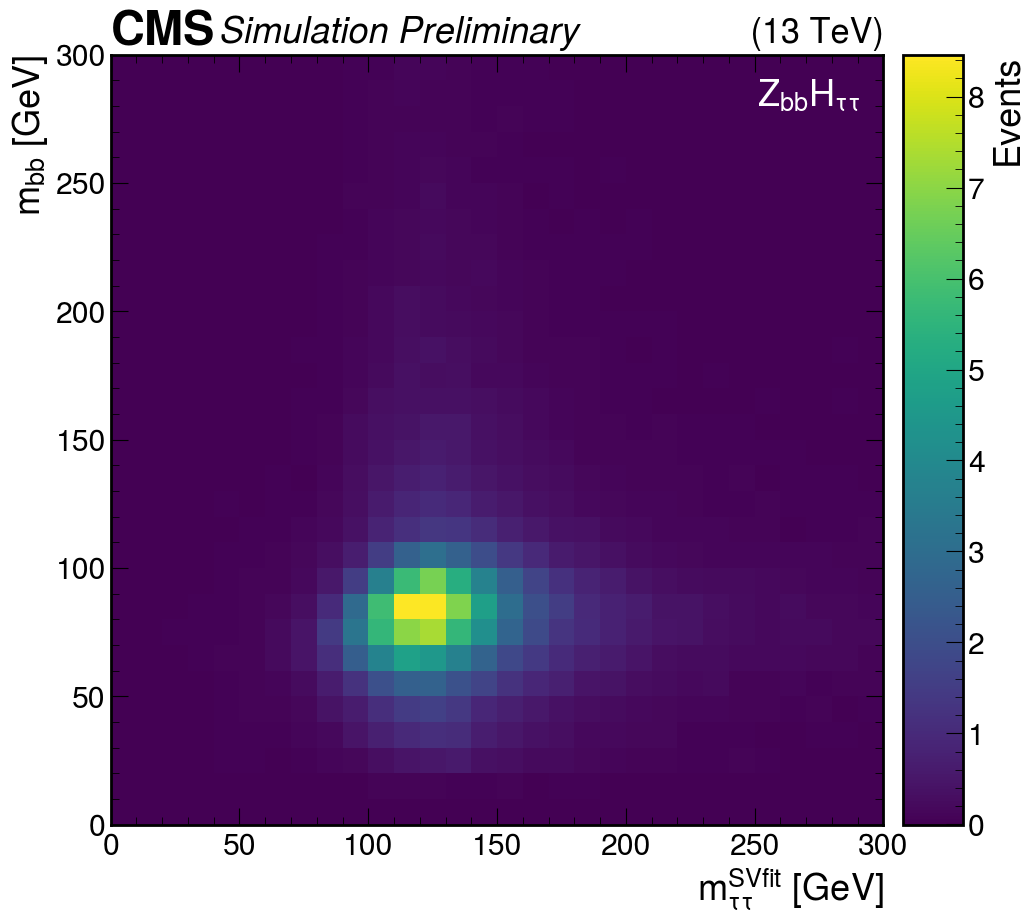

In [23]:
x_bin_edges, y_bin_edges, bin_contents = get_numpy_2D(hist_sum_zbbhtt)

plt.figure(figsize=(11, 10))
X, Y = np.meshgrid(x_bin_edges, y_bin_edges)
cbar = hep.hist2dplot(bin_contents, x_bin_edges, y_bin_edges, cmap='viridis').cbar
plt.text(0.97, 0.97, r"$Z_{bb}H_{\tau\tau}$", ha="right", va="top", transform=plt.gca().transAxes, color="white")
plt.xlabel(r"$m_{\tau\tau}^{SVfit}$ [GeV]")
plt.ylabel(r"$m_{bb}$ [GeV]")
cbar.set_label("Events")
hep.cms.label("Preliminary")
plt.xlim(0,300)
plt.ylim(0,300)

plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZbbHtt_2D.png')
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZbbHtt_2D.pdf')

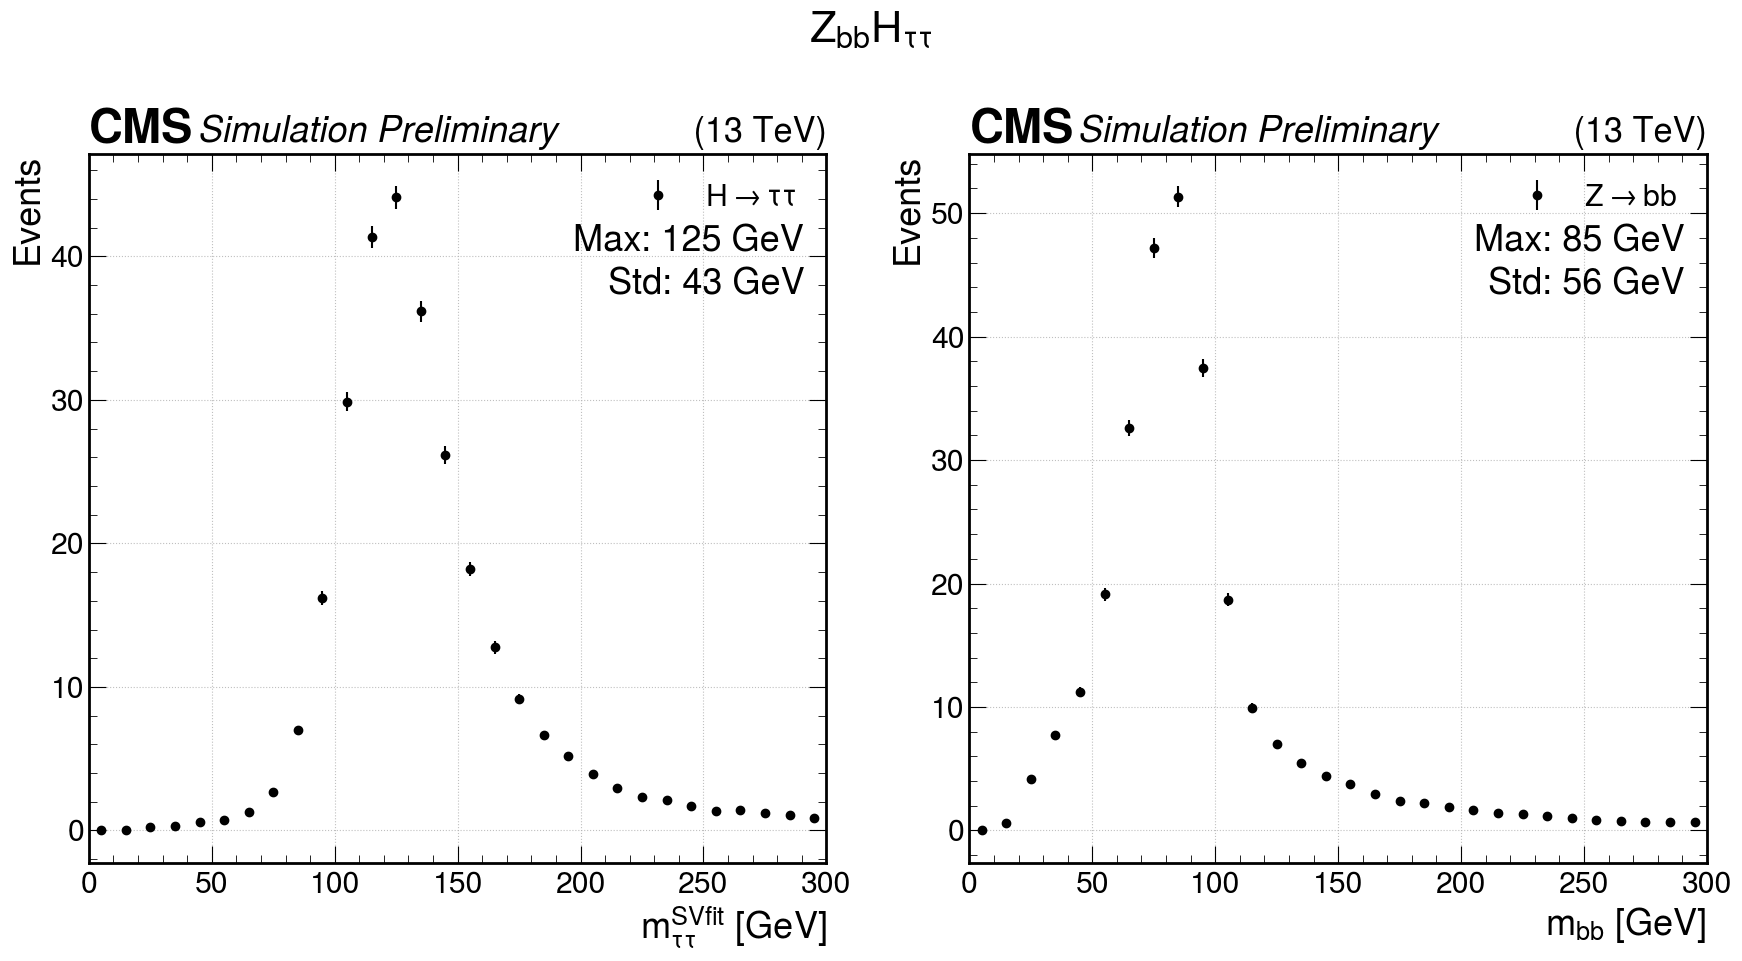

In [24]:
hist_htt = hist_sum_zbbhtt.ProjectionX()
hist_zbb = hist_sum_zbbhtt.ProjectionY()
htt_c = hist_htt.GetXaxis().GetBinCenter(hist_htt.GetMaximumBin())
htt_s = hist_htt.GetStdDev()
zbb_c = hist_zbb.GetXaxis().GetBinCenter(hist_zbb.GetMaximumBin())
zbb_s = hist_zbb.GetStdDev()

x_bin_centers, x_profile, x_profile_errors = get_numpy_1D(hist_htt)
y_bin_centers, y_profile, y_profile_errors = get_numpy_1D(hist_zbb)

fig, axs = plt.subplots(1, 2, figsize=(18, 10), sharex=True)
fig.suptitle(r"$Z_{bb}H_{\tau\tau}$")

# Plot x-profile
axs[0].errorbar(x_bin_centers, x_profile, yerr=2*x_profile_errors, fmt='o', color='black', label=rf"$H\rightarrow\tau\tau$")
axs[0].text(0.97, 0.90, rf"Max: {htt_c:.0f} GeV", ha="right", va="top", transform=axs[0].transAxes, color="black")
axs[0].text(0.97, 0.84, rf"Std: {htt_s:.0f} GeV", ha="right", va="top", transform=axs[0].transAxes, color="black")
axs[0].set_ylabel('Events')
axs[0].set_xlabel(r"$m_{\tau\tau}^{SVfit}$ [GeV]")
axs[0].set_xlim(0,300)
axs[0].legend()
axs[0].grid(True)
hep.cms.label("Preliminary", ax=axs[0])

# Plot y-profile
axs[1].errorbar(y_bin_centers, y_profile, yerr=2*y_profile_errors, fmt='o', color='black', label=rf"$Z\rightarrow bb$")
axs[1].text(0.97, 0.90, rf"Max: {zbb_c:.0f} GeV", ha="right", va="top", transform=axs[1].transAxes, color="black")
axs[1].text(0.97, 0.84, rf"Std: {zbb_s:.0f} GeV", ha="right", va="top", transform=axs[1].transAxes, color="black")
axs[1].set_xlabel(r"$m_{bb}$ [GeV]")
axs[1].set_ylabel('Events')
axs[1].set_xlim(0,300)
axs[1].legend()
axs[1].grid(True)
hep.cms.label("Preliminary", ax=axs[1])

plt.tight_layout()
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZbbHtt_Profile.png')
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZbbHtt_Profile.pdf')


H_tautau maximum = 125.0, H_tautau sigma = 42.95243654882645
Z_bb maximum = 85.0, Z_bb sigma = 56.17843646228657
Efficiency target : 0.9 >>>>> alpha = 2.33, actual efficiency = 0.90
Ellipse Coordinates : X = 125.00, R1 = 100.22, Y = 85.00, R2 = 131.08


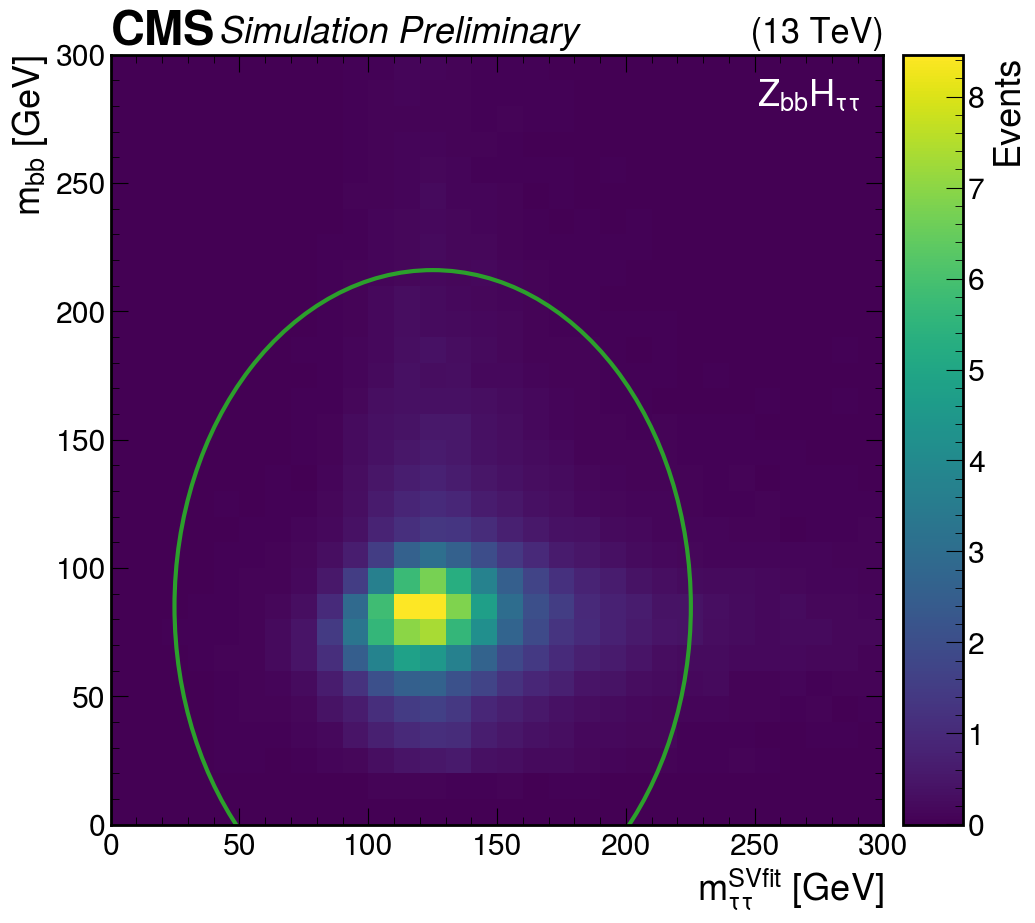

In [25]:
print(f"H_tautau maximum = {htt_c}, H_tautau sigma = {htt_s}")
print(f"Z_bb maximum = {zbb_c}, Z_bb sigma = {zbb_s}")

def computeSigEff(alpha):
        e = ROOT.TEllipse(htt_c, zbb_c, alpha*htt_s, alpha*zbb_s)
        return integrate_inside_ellipse(hist_sum_zbbhtt, e) / hist_sum_zbbhtt.Integral()
alpha_best = scipy.optimize.bisect(lambda alpha: computeSigEff(alpha) - efficiency_target, 0.1, 10, xtol=0.01)
Best_E = ROOT.TEllipse(htt_c, zbb_c, alpha_best*htt_s, alpha_best*zbb_s)
print(f"Efficiency target : {efficiency_target} >>>>> alpha = {alpha_best:.2f}, actual efficiency = {computeSigEff(alpha_best):.2f}")
print(f"Ellipse Coordinates : X = {htt_c:.2f}, R1 = {alpha_best*htt_s:.2f}, Y = {zbb_c:.2f}, R2 = {alpha_best*zbb_s:.2f}")

ellipses["ZbbHtt"] = {"x": htt_c, "y": zbb_c, "w": alpha_best*htt_s, "h": alpha_best*zbb_s}

x_bin_edges, y_bin_edges, bin_contents = get_numpy_2D(hist_sum_zbbhtt)

plt.figure(figsize=(11, 10))
X, Y = np.meshgrid(x_bin_edges, y_bin_edges)
cbar = hep.hist2dplot(bin_contents, x_bin_edges, y_bin_edges, cmap='viridis', flow=False, rasterized=True).cbar
ellipse_zbbhtt = Ellipse(xy=(ellipses["ZbbHtt"]["x"], ellipses["ZbbHtt"]["y"]), width=ellipses["ZbbHtt"]["w"]*2, height=ellipses["ZbbHtt"]["h"]*2, fill=False, ec="tab:green", lw=3)
plt.gca().add_patch(ellipse_zbbhtt)
plt.text(0.97, 0.97, r"$Z_{bb}H_{\tau\tau}$", ha="right", va="top", transform=plt.gca().transAxes, color="white")
plt.xlabel(r"$m_{\tau\tau}^{SVfit}$ [GeV]")
plt.ylabel(r"$m_{bb}$ [GeV]")
cbar.set_label("Events")
hep.cms.label("Preliminary")
plt.xlim(0,300)
plt.ylim(0,300)

plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZbbHtt_Ellipse.png')
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZbbHtt_Ellipse.pdf')

# Ztt Hbb

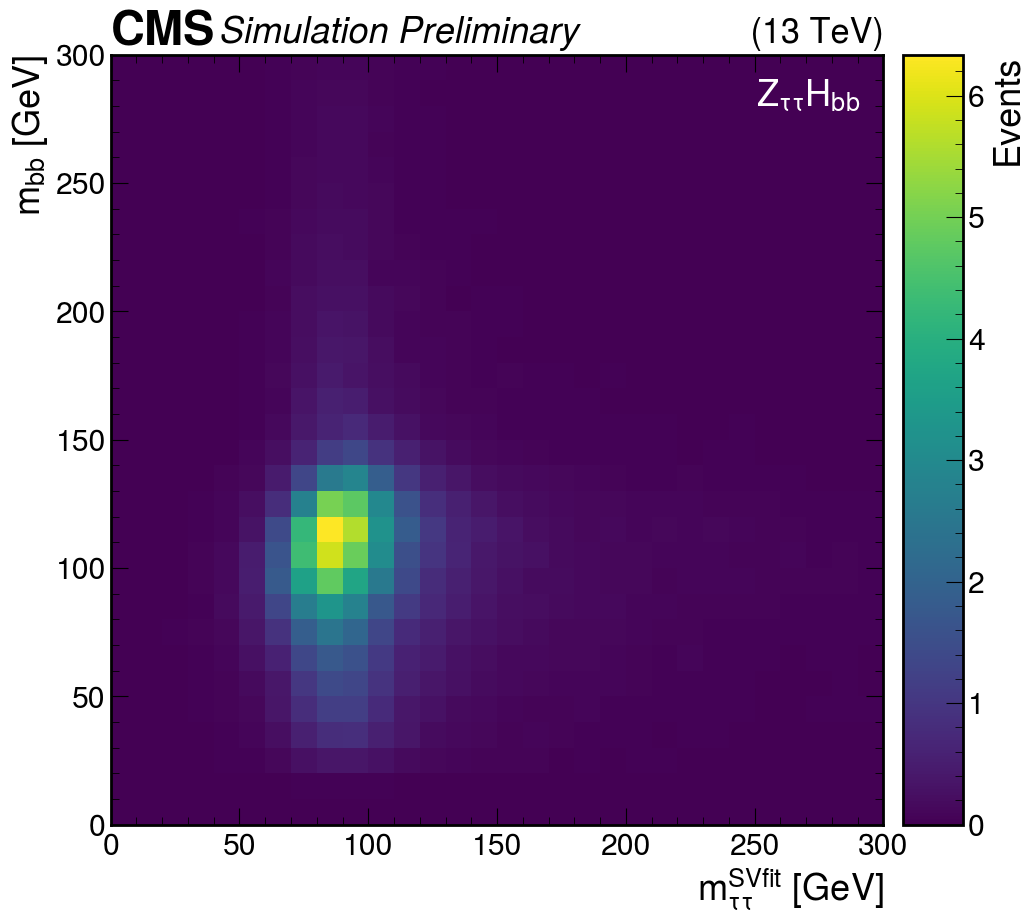

In [26]:
x_bin_edges, y_bin_edges, bin_contents = get_numpy_2D(hist_sum_ztthbb)

plt.figure(figsize=(11, 10))
X, Y = np.meshgrid(x_bin_edges, y_bin_edges)
cbar = hep.hist2dplot(bin_contents, x_bin_edges, y_bin_edges, cmap='viridis', flow=False, rasterized=True).cbar
plt.text(0.97, 0.97, r"$Z_{\tau\tau}H_{bb}$", ha="right", va="top", transform=plt.gca().transAxes, color="white")
plt.xlabel(r"$m_{\tau\tau}^{SVfit}$ [GeV]")
plt.ylabel(r"$m_{bb}$ [GeV]")
cbar.set_label("Events")
hep.cms.label("Preliminary")
plt.xlim(0,300)
plt.ylim(0,300)

plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZttHbb_2D.png')
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZttHbb_2D.pdf')

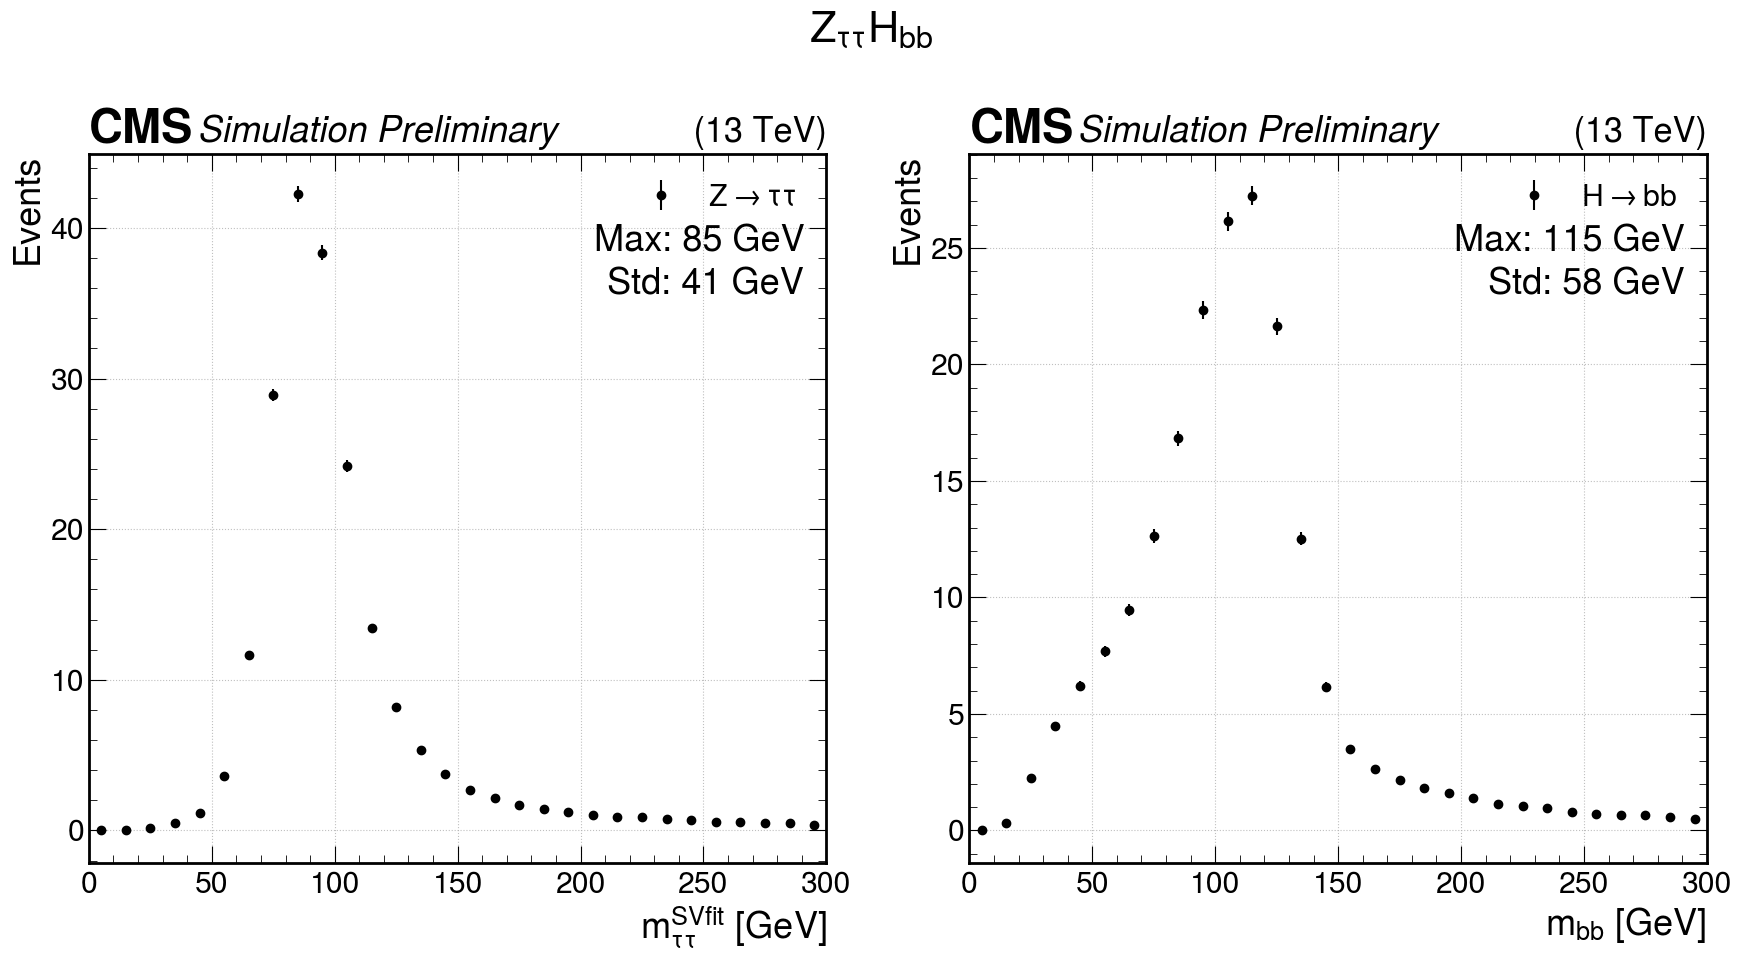

In [27]:
hist_ztt = hist_sum_ztthbb.ProjectionX()
hist_hbb = hist_sum_ztthbb.ProjectionY()
ztt_c = hist_ztt.GetXaxis().GetBinCenter(hist_ztt.GetMaximumBin())
ztt_s = hist_ztt.GetStdDev()
hbb_c = hist_hbb.GetXaxis().GetBinCenter(hist_hbb.GetMaximumBin())
hbb_s = hist_hbb.GetStdDev()

x_bin_centers, x_profile, x_profile_errors = get_numpy_1D(hist_ztt)
y_bin_centers, y_profile, y_profile_errors = get_numpy_1D(hist_hbb)

fig, axs = plt.subplots(1, 2, figsize=(18, 10), sharex=True)
fig.suptitle(r"$Z_{\tau\tau}H_{bb}$")

# Plot x-profile
axs[0].errorbar(x_bin_centers, x_profile, yerr=2*x_profile_errors, fmt='o', color='black', label=rf"$Z\rightarrow\tau\tau$")
axs[0].text(0.97, 0.90, rf"Max: {ztt_c:.0f} GeV", ha="right", va="top", transform=axs[0].transAxes, color="black")
axs[0].text(0.97, 0.84, rf"Std: {ztt_s:.0f} GeV", ha="right", va="top", transform=axs[0].transAxes, color="black")
axs[0].set_ylabel('Events')
axs[0].set_xlabel(r"$m_{\tau\tau}^{SVfit}$ [GeV]")
axs[0].set_xlim(0,300)
axs[0].legend()
axs[0].grid(True)
hep.cms.label("Preliminary", ax=axs[0])

# Plot y-profile
axs[1].errorbar(y_bin_centers, y_profile, yerr=2*y_profile_errors, fmt='o', color='black', label=rf"$H\rightarrow bb$")
axs[1].text(0.97, 0.90, rf"Max: {hbb_c:.0f} GeV", ha="right", va="top", transform=axs[1].transAxes, color="black")
axs[1].text(0.97, 0.84, rf"Std: {hbb_s:.0f} GeV", ha="right", va="top", transform=axs[1].transAxes, color="black")
axs[1].set_xlabel(r"$m_{bb}$ [GeV]")
axs[1].set_ylabel('Events')
axs[1].set_xlim(0,300)
axs[1].legend()
axs[1].grid(True)
hep.cms.label("Preliminary", ax=axs[1])

plt.tight_layout()
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZttHbb_Profile.png')
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZttHbb_Profile.pdf')

Z_tautau maximum = 85.0, Z_tautau sigma = 41.16228223176387
H_bb maximum = 115.0, H_bb sigma = 58.27292545417802
Efficiency target : 0.9 >>>>> alpha = 2.24, actual efficiency = 0.90
Ellipse Coordinates : X = 85.00, R1 = 92.06, Y = 115.00, R2 = 130.33


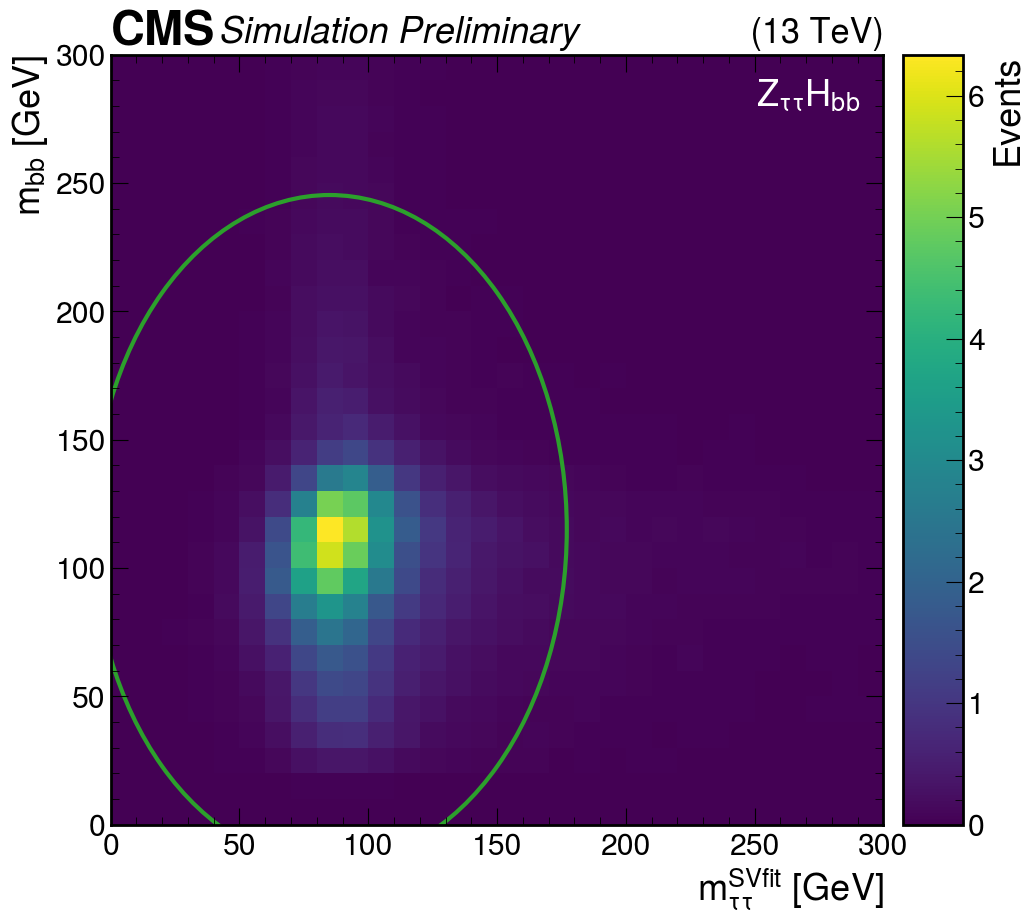

In [28]:
print(f"Z_tautau maximum = {ztt_c}, Z_tautau sigma = {ztt_s}")
print(f"H_bb maximum = {hbb_c}, H_bb sigma = {hbb_s}")

def computeSigEff(alpha):
        e = ROOT.TEllipse(ztt_c, hbb_c, alpha*ztt_s, alpha*hbb_s)
        return integrate_inside_ellipse(hist_sum_ztthbb, e) / hist_sum_ztthbb.Integral()
alpha_best = scipy.optimize.bisect(lambda alpha: computeSigEff(alpha) - efficiency_target, 0.1, 10, xtol=0.01)
Best_E = ROOT.TEllipse(ztt_c, hbb_c, alpha_best*ztt_s, alpha_best*hbb_s)
print(f"Efficiency target : {efficiency_target} >>>>> alpha = {alpha_best:.2f}, actual efficiency = {computeSigEff(alpha_best):.2f}")
print(f"Ellipse Coordinates : X = {ztt_c:.2f}, R1 = {alpha_best*ztt_s:.2f}, Y = {hbb_c:.2f}, R2 = {alpha_best*hbb_s:.2f}")

ellipses["ZttHbb"] = {"x": ztt_c, "y": hbb_c, "w": alpha_best*ztt_s, "h": alpha_best*hbb_s}

x_bin_edges, y_bin_edges, bin_contents = get_numpy_2D(hist_sum_ztthbb)

plt.figure(figsize=(11, 10))
X, Y = np.meshgrid(x_bin_edges, y_bin_edges)
cbar = hep.hist2dplot(bin_contents, x_bin_edges, y_bin_edges, cmap='viridis', flow=False, rasterized=True).cbar
ellipse_ztthbb = Ellipse(xy=(ellipses["ZttHbb"]["x"], ellipses["ZttHbb"]["y"]), width=ellipses["ZttHbb"]["w"]*2, height=ellipses["ZttHbb"]["h"]*2, fill=False, ec="tab:green", lw=3)
plt.gca().add_patch(ellipse_ztthbb)
plt.text(0.97, 0.97, r"$Z_{\tau\tau}H_{bb}$", ha="right", va="top", transform=plt.gca().transAxes, color="white")
plt.xlabel(r"$m_{\tau\tau}^{SVfit}$ [GeV]")
plt.ylabel(r"$m_{bb}$ [GeV]")
cbar.set_label("Events")
hep.cms.label("Preliminary")
plt.xlim(0,300)
plt.ylim(0,300)

plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZttHbb_Ellipse.png')
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZttHbb_Ellipse.pdf')

# ZZbbtt

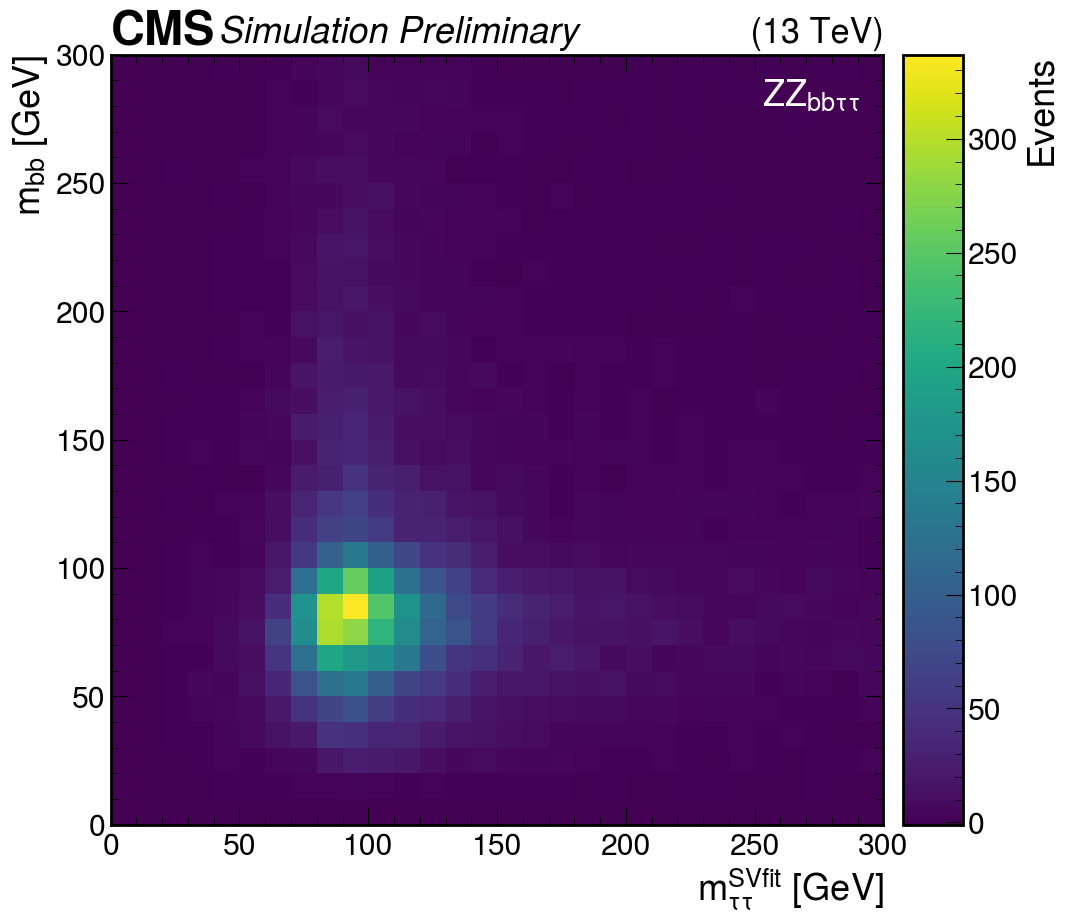

In [29]:
x_bin_edges, y_bin_edges, bin_contents = get_numpy_2D(hist_sum_zzbbtt)

plt.figure(figsize=(11, 10))
X, Y = np.meshgrid(x_bin_edges, y_bin_edges)
cbar = hep.hist2dplot(bin_contents, x_bin_edges, y_bin_edges, cmap='viridis', flow=False, rasterized=True).cbar
plt.text(0.97, 0.97, r"$ZZ_{bb\tau\tau}$", ha="right", va="top", transform=plt.gca().transAxes, color="white")
plt.xlabel(r"$m_{\tau\tau}^{SVfit}$ [GeV]")
plt.ylabel(r"$m_{bb}$ [GeV]")
cbar.set_label("Events")
hep.cms.label("Preliminary")
plt.xlim(0,300)
plt.ylim(0,300)

plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZZbbtt_2D.png')
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZZbbtt_2D.pdf')

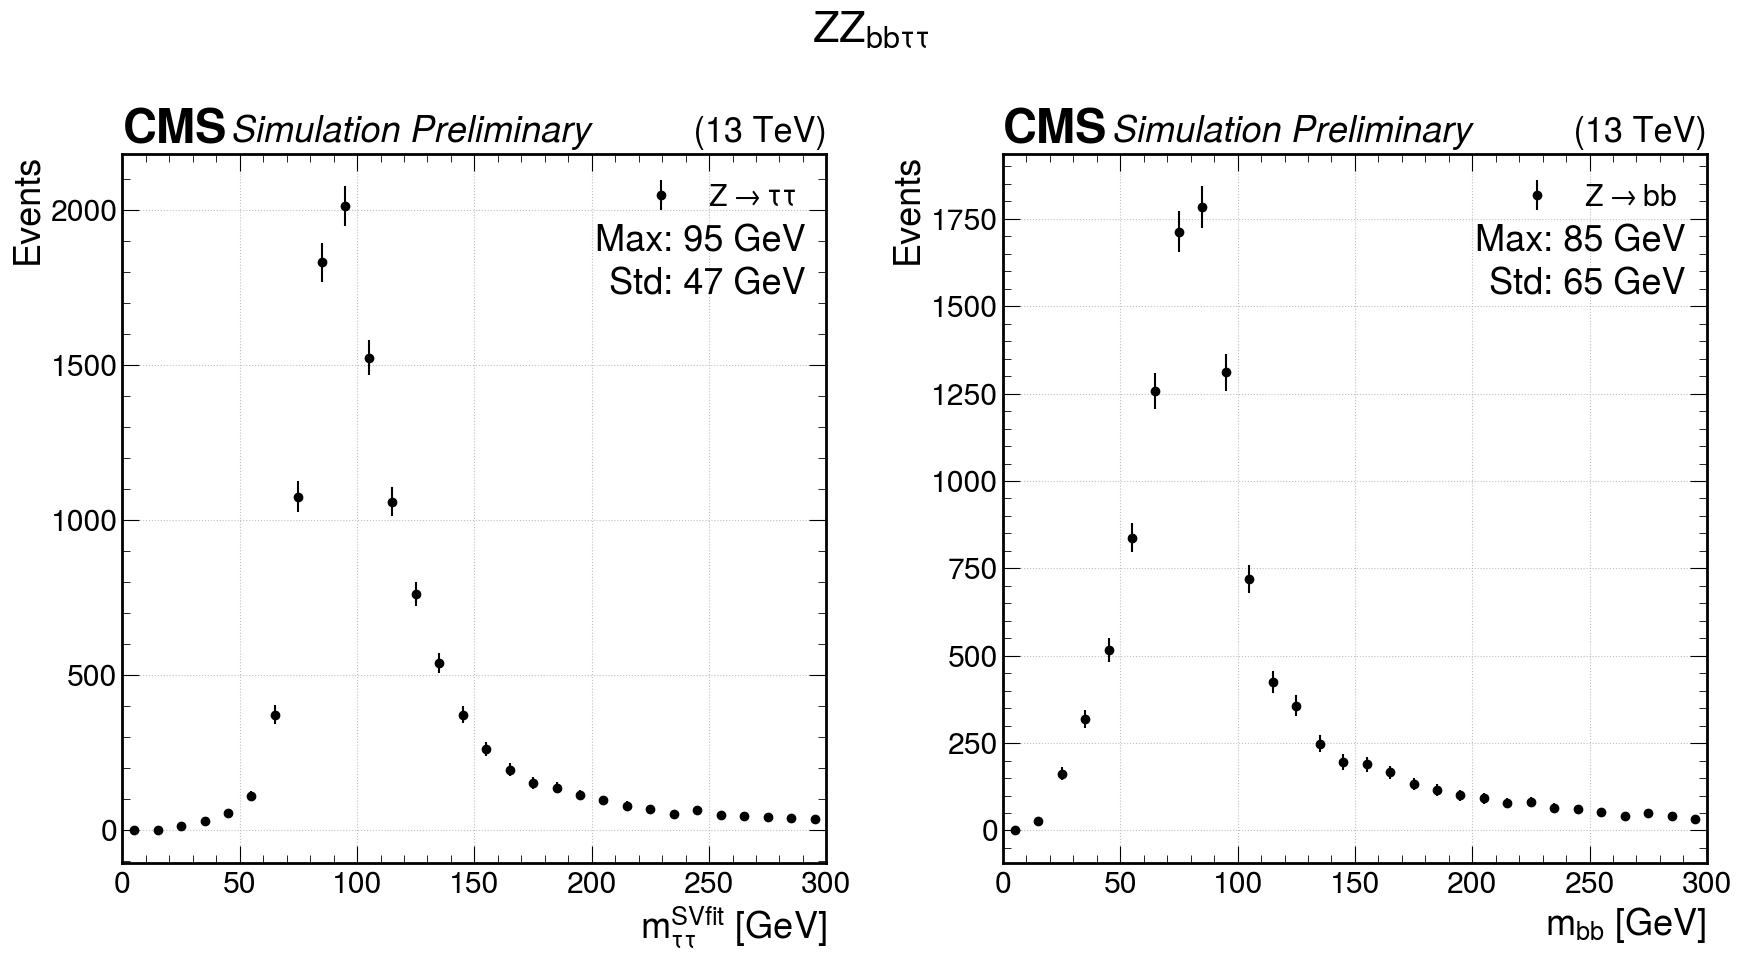

In [30]:
hist_ztt = hist_sum_zzbbtt.ProjectionX()
hist_zbb = hist_sum_zzbbtt.ProjectionY()
zztt_c = hist_ztt.GetXaxis().GetBinCenter(hist_ztt.GetMaximumBin())
zztt_s = hist_ztt.GetStdDev()
zzbb_c = hist_zbb.GetXaxis().GetBinCenter(hist_zbb.GetMaximumBin())
zzbb_s = hist_zbb.GetStdDev()

x_bin_centers, x_profile, x_profile_errors = get_numpy_1D(hist_ztt)
y_bin_centers, y_profile, y_profile_errors = get_numpy_1D(hist_zbb)

fig, axs = plt.subplots(1, 2, figsize=(18, 10), sharex=True)
fig.suptitle(r"$ZZ_{bb\tau\tau}$")

# Plot x-profile
axs[0].errorbar(x_bin_centers, x_profile, yerr=2*x_profile_errors, fmt='o', color='black', label=rf"$Z\rightarrow\tau\tau$")
axs[0].text(0.97, 0.90, rf"Max: {zztt_c:.0f} GeV", ha="right", va="top", transform=axs[0].transAxes, color="black")
axs[0].text(0.97, 0.84, rf"Std: {zztt_s:.0f} GeV", ha="right", va="top", transform=axs[0].transAxes, color="black")
axs[0].set_ylabel('Events')
axs[0].set_xlabel(r"$m_{\tau\tau}^{SVfit}$ [GeV]")
axs[0].set_xlim(0,300)
axs[0].legend()
axs[0].grid(True)
hep.cms.label("Preliminary", ax=axs[0])

# Plot y-profile
axs[1].errorbar(y_bin_centers, y_profile, yerr=2*y_profile_errors, fmt='o', color='black', label=rf"$Z\rightarrow bb$")
axs[1].text(0.97, 0.90, rf"Max: {zzbb_c:.0f} GeV", ha="right", va="top", transform=axs[1].transAxes, color="black")
axs[1].text(0.97, 0.84, rf"Std: {zzbb_s:.0f} GeV", ha="right", va="top", transform=axs[1].transAxes, color="black")
axs[1].set_xlabel(r"$m_{bb}$ [GeV]")
axs[1].set_ylabel('Events')
axs[1].set_xlim(0,300)
axs[1].legend()
axs[1].grid(True)
hep.cms.label("Preliminary", ax=axs[1])

plt.tight_layout()
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZZbbtt_Profile.png')
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZZbbtt_Profile.pdf')

Z_tautau maximum = 95.0, Z_tautau sigma = 47.131768616291374
Z_bb maximum = 85.0, Z_bb sigma = 65.01282749857695
Efficiency target : 0.9 >>>>> alpha = 2.55, actual efficiency = 0.90
Ellipse Coordinates : X = 95.00, R1 = 120.00, Y = 85.00, R2 = 165.52


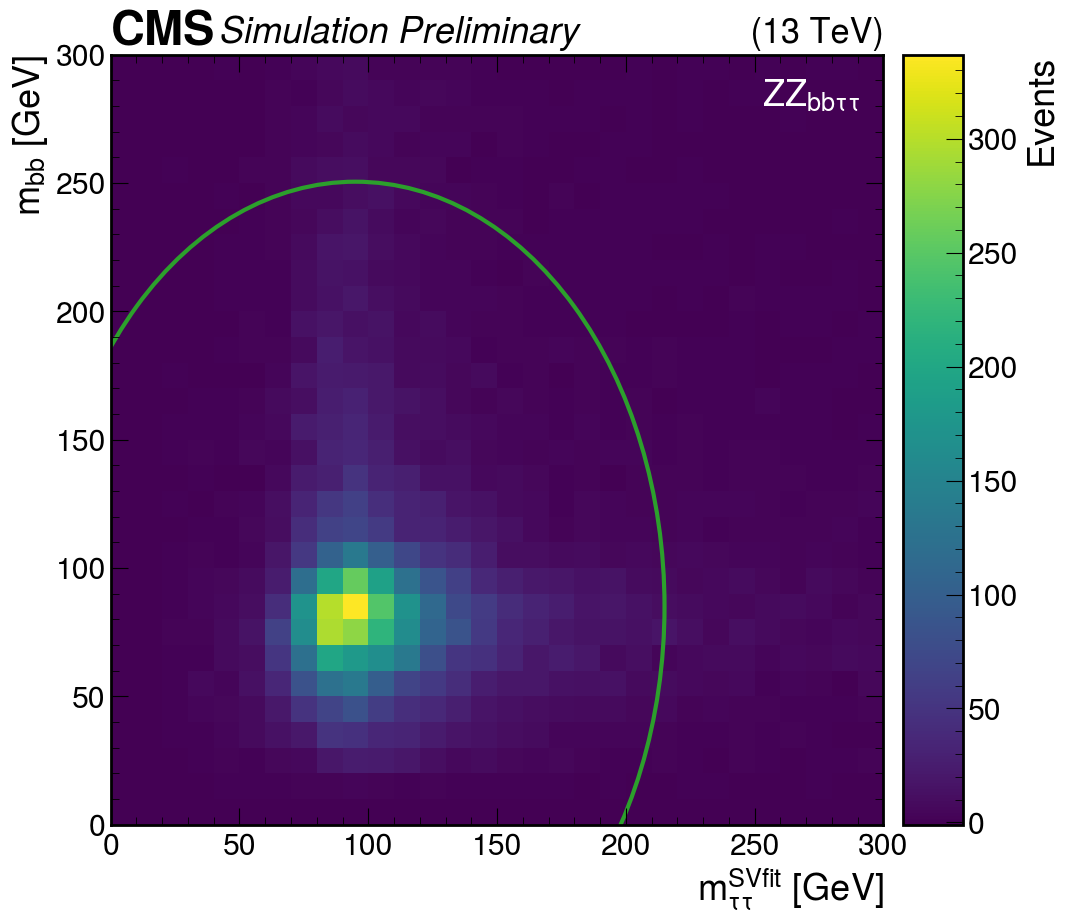

In [31]:
print(f"Z_tautau maximum = {zztt_c}, Z_tautau sigma = {zztt_s}")
print(f"Z_bb maximum = {zzbb_c}, Z_bb sigma = {zzbb_s}")

def computeSigEff(alpha):
        e = ROOT.TEllipse(zztt_c, zzbb_c, alpha*zztt_s, alpha*zzbb_s)
        return integrate_inside_ellipse(hist_sum_zzbbtt, e) / hist_sum_zzbbtt.Integral()
alpha_best = scipy.optimize.bisect(lambda alpha: computeSigEff(alpha) - efficiency_target, 0.1, 10, xtol=0.01)
Best_E = ROOT.TEllipse(zztt_c, zzbb_c, alpha_best*zztt_s, alpha_best*zzbb_s)
print(f"Efficiency target : {efficiency_target} >>>>> alpha = {alpha_best:.2f}, actual efficiency = {computeSigEff(alpha_best):.2f}")
print(f"Ellipse Coordinates : X = {zztt_c:.2f}, R1 = {alpha_best*zztt_s:.2f}, Y = {zzbb_c:.2f}, R2 = {alpha_best*zzbb_s:.2f}")

ellipses["ZZbbtt"] = {"x": zztt_c, "y": zzbb_c, "w": alpha_best*zztt_s, "h": alpha_best*zzbb_s}

x_bin_edges, y_bin_edges, bin_contents = get_numpy_2D(hist_sum_zzbbtt)

plt.figure(figsize=(11, 10))
X, Y = np.meshgrid(x_bin_edges, y_bin_edges)
cbar = hep.hist2dplot(bin_contents, x_bin_edges, y_bin_edges, cmap='viridis', flow=False, rasterized=True).cbar
ellipse_zzbbtt = Ellipse(xy=(ellipses["ZZbbtt"]["x"], ellipses["ZZbbtt"]["y"]), width=ellipses["ZZbbtt"]["w"]*2, height=ellipses["ZZbbtt"]["h"]*2, fill=False, ec="tab:green", lw=3)
plt.gca().add_patch(ellipse_zzbbtt)
plt.text(0.97, 0.97, r"$ZZ_{bb\tau\tau}$", ha="right", va="top", transform=plt.gca().transAxes, color="white")
plt.xlabel(r"$m_{\tau\tau}^{SVfit}$ [GeV]")
plt.ylabel(r"$m_{bb}$ [GeV]")
cbar.set_label("Events")
hep.cms.label("Preliminary")
plt.xlim(0,300)
plt.ylim(0,300)

plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZZbbtt_Ellipse.png')
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZZbbtt_Ellipse.pdf')

In [32]:
ellipses

{'ZbbHtt': {'x': 125.0,
  'y': 85.0,
  'w': 100.22095375596783,
  'h': 131.08118968685676},
 'ZttHbb': {'x': 85.0,
  'y': 115.0,
  'w': 92.0644287064539,
  'h': 130.33445426533586},
 'ZZbbtt': {'x': 95.0,
  'y': 85.0,
  'w': 119.9972987886067,
  'h': 165.52240485501954}}

# Orthogonality ZH


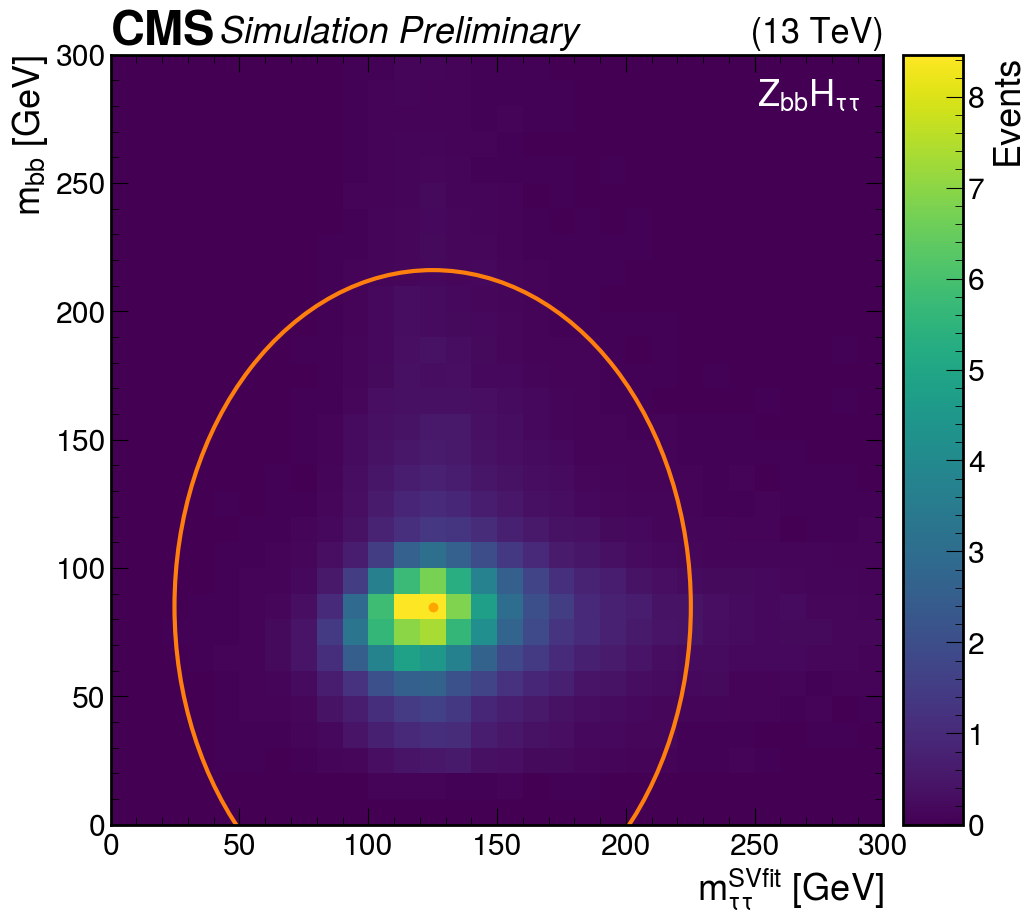

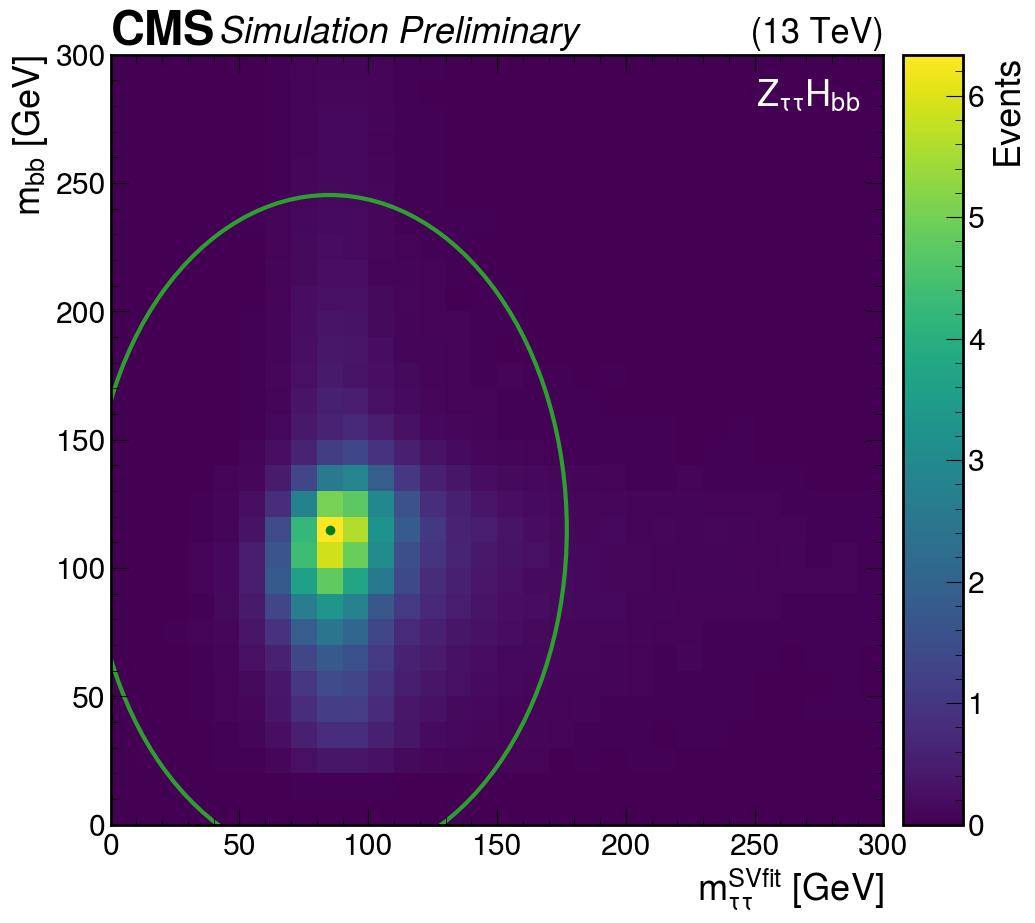

In [33]:
# Plot the stacked ZbbHtt histogram
xedges, yedges, stacked_data_zbbhtt = get_numpy_2D(hist_sum_zbbhtt)
xedges, yedges, stacked_data_ztthbb = get_numpy_2D(hist_sum_ztthbb)

plt.figure(figsize=(11, 10))
cbar = hep.hist2dplot(stacked_data_zbbhtt, xedges, yedges, cmap='viridis', flow=False, rasterized=True).cbar
plt.scatter(htt_c,zbb_c, color="orange")
plt.xlim(0,300)
plt.ylim(0,300)
ellipse_zbbhtt = Ellipse(xy=(ellipses["ZbbHtt"]["x"], ellipses["ZbbHtt"]["y"]), width=ellipses["ZbbHtt"]["w"]*2, height=ellipses["ZbbHtt"]["h"]*2, fill=False, ec="tab:orange", lw=3)
plt.gca().add_patch(ellipse_zbbhtt)
plt.text(0.97, 0.97, r"$Z_{bb}H_{\tau\tau}$", ha="right", va="top", transform=plt.gca().transAxes, color="white")
cbar.set_label("Events")
hep.cms.label("Preliminary")
plt.xlabel(r"$m_{\tau\tau}^{SVfit}$ [GeV]")
plt.ylabel(r"$m_{bb}$ [GeV]")

plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZbbHtt_EllipseCenter.png')
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZbbHtt_EllipseCenter.pdf')

# Plot the stacked ZttHbb histogram
plt.figure(figsize=(11, 10))
cbar = hep.hist2dplot(stacked_data_ztthbb, xedges, yedges, cmap='viridis', flow=False, rasterized=True).cbar
plt.scatter(ztt_c,hbb_c, color="green")
plt.xlim(0,300)
plt.ylim(0,300)
ellipse_zbbhtt = Ellipse(xy=(ellipses["ZttHbb"]["x"], ellipses["ZttHbb"]["y"]), width=ellipses["ZttHbb"]["w"]*2, height=ellipses["ZttHbb"]["h"]*2, fill=False, ec="tab:green", lw=3)
plt.gca().add_patch(ellipse_zbbhtt)
plt.text(0.97, 0.97, r"$Z_{\tau\tau}H_{bb}$", ha="right", va="top", transform=plt.gca().transAxes, color="white")
cbar.set_label("Events")
hep.cms.label("Preliminary")
plt.xlabel(r"$m_{\tau\tau}^{SVfit}$ [GeV]")
plt.ylabel(r"$m_{bb}$ [GeV]")

plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZttHbb_EllipseCenter.png')
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZttHbb_EllipseCenter.pdf')

/tmp/ipykernel_141353/877042958.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_line_perp, y_line_perp, 'k-', linewidth=2, color='aqua', label=f'Line: y = {a_perp:.2f}x + {b_perp:.2f}')


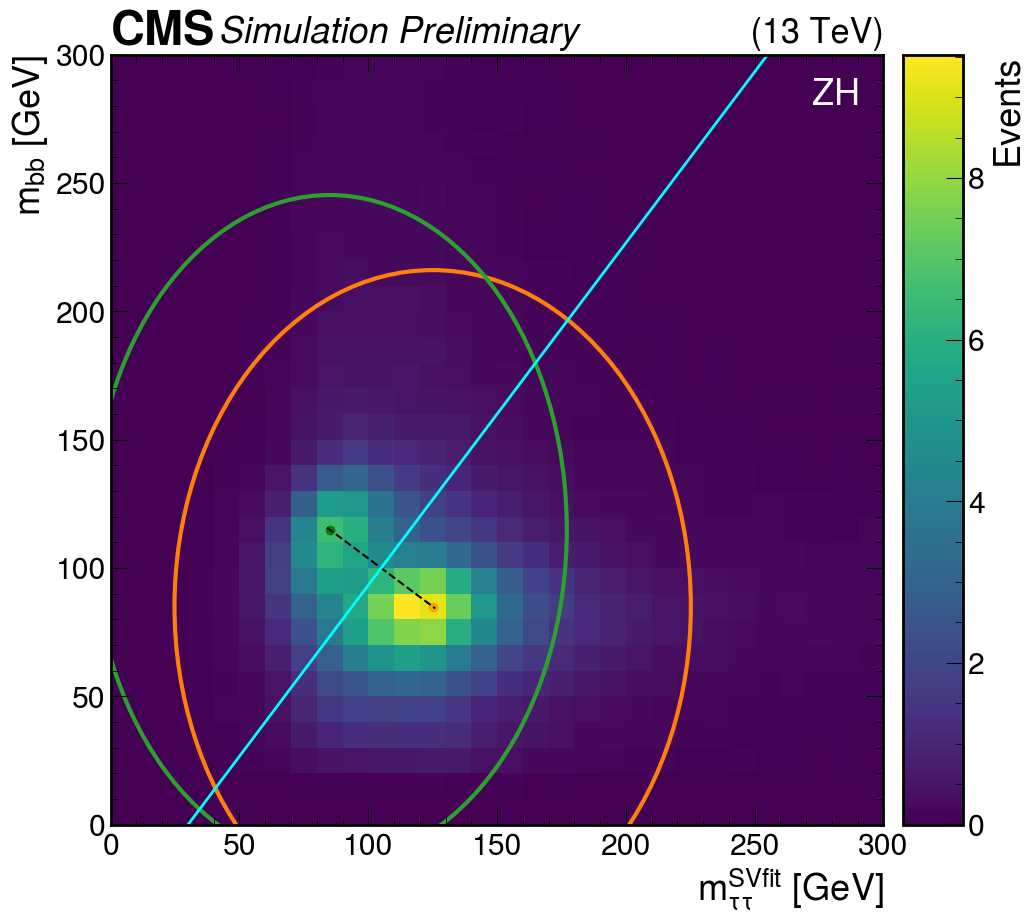

In [34]:
stacked_data = stacked_data_zbbhtt + stacked_data_ztthbb

def line(x, a, b): return a * x + b

# Plot the stacked histogram
plt.figure(figsize=(11, 10))
cbar = hep.hist2dplot(stacked_data, xedges, yedges, cmap='viridis', flow=False, rasterized=True).cbar
plt.scatter(htt_c,zbb_c, color="orange")
plt.scatter(ztt_c,hbb_c, color="green")
plt.xlim(0,300)
plt.ylim(0,300)
ellipse_zbbhtt = Ellipse(xy=(ellipses["ZbbHtt"]["x"], ellipses["ZbbHtt"]["y"]), width=ellipses["ZbbHtt"]["w"]*2, height=ellipses["ZbbHtt"]["h"]*2, fill=False, ec="tab:orange", lw=3)
ellipse_ztthbb = Ellipse(xy=(ellipses["ZttHbb"]["x"], ellipses["ZttHbb"]["y"]), width=ellipses["ZttHbb"]["w"]*2, height=ellipses["ZttHbb"]["h"]*2, fill=False, ec="tab:green", lw=3)
plt.gca().add_patch(ellipse_zbbhtt)
plt.gca().add_patch(ellipse_ztthbb)
plt.text(0.97, 0.97, "ZH", ha="right", va="top", transform=plt.gca().transAxes, color="white")
cbar.set_label("Events")
hep.cms.label("Preliminary")
plt.xlabel(r"$m_{\tau\tau}^{SVfit}$ [GeV]")
plt.ylabel(r"$m_{bb}$ [GeV]")

a = (hbb_c - zbb_c)/(ztt_c - htt_c)
b = zbb_c - a * htt_c
x_line = np.linspace(min(ztt_c, htt_c) - 1, max(ztt_c, htt_c) + 1, 10)
y_line = line(x_line, a, b)
plt.plot(x_line, y_line, '--', color='black', label=f'Line: y = {a:.2f}x + {b:.2f}')

x_m = (htt_c + ztt_c) / 2
y_m = (zbb_c + hbb_c) / 2
a_perp = - 1 / a
b_perp = y_m - a_perp * x_m
x_line_perp = np.linspace(0, 300, 100)
y_line_perp = line(x_line_perp, a_perp, b_perp)
plt.plot(x_line_perp, y_line_perp, 'k-', linewidth=2, color='aqua', label=f'Line: y = {a_perp:.2f}x + {b_perp:.2f}')

plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZH_Ellipse_PerpendicularLine.png')
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZH_Ellipse_PerpendicularLine.pdf')

/tmp/ipykernel_141353/4189304657.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_line_perp, y_line_perp, 'k-', linewidth=3, color='green', label=f'Line: y = {a_perp:.2f}x + {b_perp:.2f}')
/tmp/ipykernel_141353/4189304657.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(ellipse_x_above, ellipse_y_above, 'r-', linewidth=3, color='green', label='Ellipse Contour Above Line')
/tmp/ipykernel_141353/4189304657.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(ellipse_x_below, ellipse_y_below, 'r-', linewidth=3, color='orange', label='Ellipse Contour Below Line')


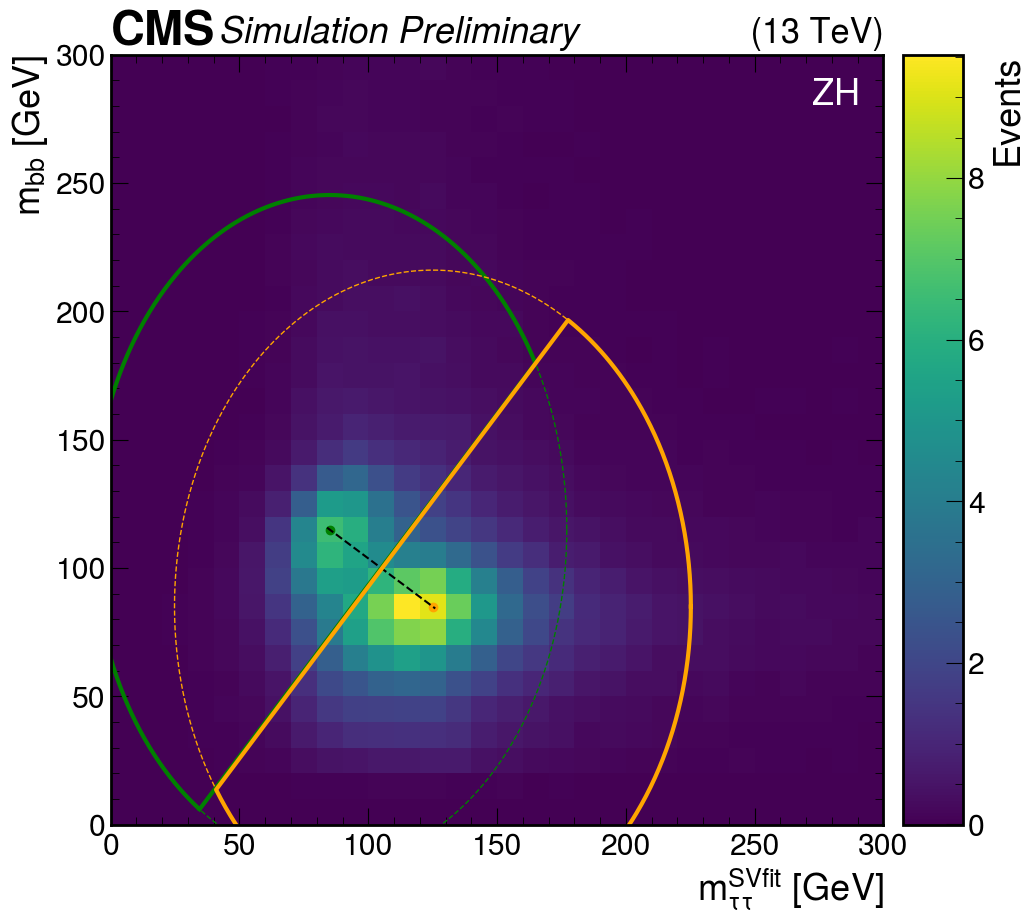

In [35]:
def line(x, a, b): return a * x + b

# Plot the stacked histogram
plt.figure(figsize=(11, 10))
cbar = hep.hist2dplot(stacked_data, xedges, yedges, cmap='viridis', flow=False, rasterized=True).cbar
plt.scatter(htt_c,zbb_c, color="orange")
plt.scatter(ztt_c,hbb_c, color="green")
plt.xlim(0,300)
plt.ylim(0,300)
ellipse_zbbhtt = Ellipse(xy=(ellipses["ZbbHtt"]["x"], ellipses["ZbbHtt"]["y"]), width=ellipses["ZbbHtt"]["w"]*2, height=ellipses["ZbbHtt"]["h"]*2, fill=False, ec="tab:orange", lw=3)
ellipse_ztthbb = Ellipse(xy=(ellipses["ZttHbb"]["x"], ellipses["ZttHbb"]["y"]), width=ellipses["ZttHbb"]["w"]*2, height=ellipses["ZttHbb"]["h"]*2, fill=False, ec="tab:green", lw=3)
# plt.gca().add_patch(ellipse_zbbhtt)
# plt.gca().add_patch(ellipse_ztthbb)
plt.text(0.97, 0.97, "ZH", ha="right", va="top", transform=plt.gca().transAxes, color="white")
cbar.set_label("Events")
hep.cms.label("Preliminary")
plt.xlabel(r"$m_{\tau\tau}^{SVfit}$ [GeV]")
plt.ylabel(r"$m_{bb}$ [GeV]")

a = (hbb_c - zbb_c)/(ztt_c - htt_c)
b = zbb_c - a * htt_c
x_line = np.linspace(min(ztt_c, htt_c) - 1, max(ztt_c, htt_c) + 1, 10)
y_line = line(x_line, a, b)
plt.plot(x_line, y_line, '--', color='black', label=f'Line: y = {a:.2f}x + {b:.2f}')

x_m = (htt_c + ztt_c) / 2
y_m = (zbb_c + hbb_c) / 2
a_perp = - 1 / a
b_perp = y_m - a_perp * x_m
x_line_perp = np.linspace(34.5, 164.5, 100)
y_line_perp = line(x_line_perp, a_perp, b_perp)
plt.plot(x_line_perp, y_line_perp, 'k-', linewidth=3, color='green', label=f'Line: y = {a_perp:.2f}x + {b_perp:.2f}')

# Parametric equations for ellipse points
theta = np.linspace(0, 2 * np.pi, 1000)
ellipse_x = ellipses["ZttHbb"]["x"] + ellipses["ZttHbb"]["w"] * np.cos(theta)
ellipse_y = ellipses["ZttHbb"]["y"] + ellipses["ZttHbb"]["h"] * np.sin(theta)
points_above_line = (ellipse_y > line(ellipse_x, a_perp, b_perp))
ellipse_x_above = ellipse_x[points_above_line]
ellipse_y_above = ellipse_y[points_above_line]
plt.plot(ellipse_x_above, ellipse_y_above, 'r-', linewidth=3, color='green', label='Ellipse Contour Above Line')

points_below_line = (ellipse_y < line(ellipse_x, a_perp, b_perp))
ellipse_x_below = ellipse_x[points_below_line]
ellipse_y_below = ellipse_y[points_below_line]
plt.plot(ellipse_x_below, ellipse_y_below, '--', linewidth=1, color='green', label='Ellipse Contour Above Line')

ellipse_x = ellipses["ZbbHtt"]["x"] + ellipses["ZbbHtt"]["w"] * np.cos(theta)
ellipse_y = ellipses["ZbbHtt"]["y"] + ellipses["ZbbHtt"]["h"] * np.sin(theta)
points_below_line = (ellipse_y < line(ellipse_x, a_perp, b_perp))
ellipse_x_below = ellipse_x[points_below_line]
ellipse_y_below = ellipse_y[points_below_line]
plt.plot(ellipse_x_below, ellipse_y_below, 'r-', linewidth=3, color='orange', label='Ellipse Contour Below Line')

points_above_line = (ellipse_y > line(ellipse_x, a_perp, b_perp))
ellipse_x_above = ellipse_x[points_above_line]
ellipse_y_above = ellipse_y[points_above_line]
plt.plot(ellipse_x_above, ellipse_y_above, '--', linewidth=1, color='orange', label='Ellipse Contour Below Line')

plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZH_Ellipse_Orthogonal.png')
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZH_Ellipse_Orthogonal.pdf')

/tmp/ipykernel_141353/2846743754.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(ellipse_x_below, ellipse_y_below, 'r-', linewidth=3, color='orange', label='Ellipse Contour Below Line')


/tmp/ipykernel_141353/2846743754.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_line_perp, y_line_perp, 'k-', linewidth=3, color='green', label=f'Line: y = {a_perp:.2f}x + {b_perp:.2f}')
/tmp/ipykernel_141353/2846743754.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(ellipse_x_above, ellipse_y_above, 'r-', linewidth=3, color='green', label='Ellipse Contour Above Line')


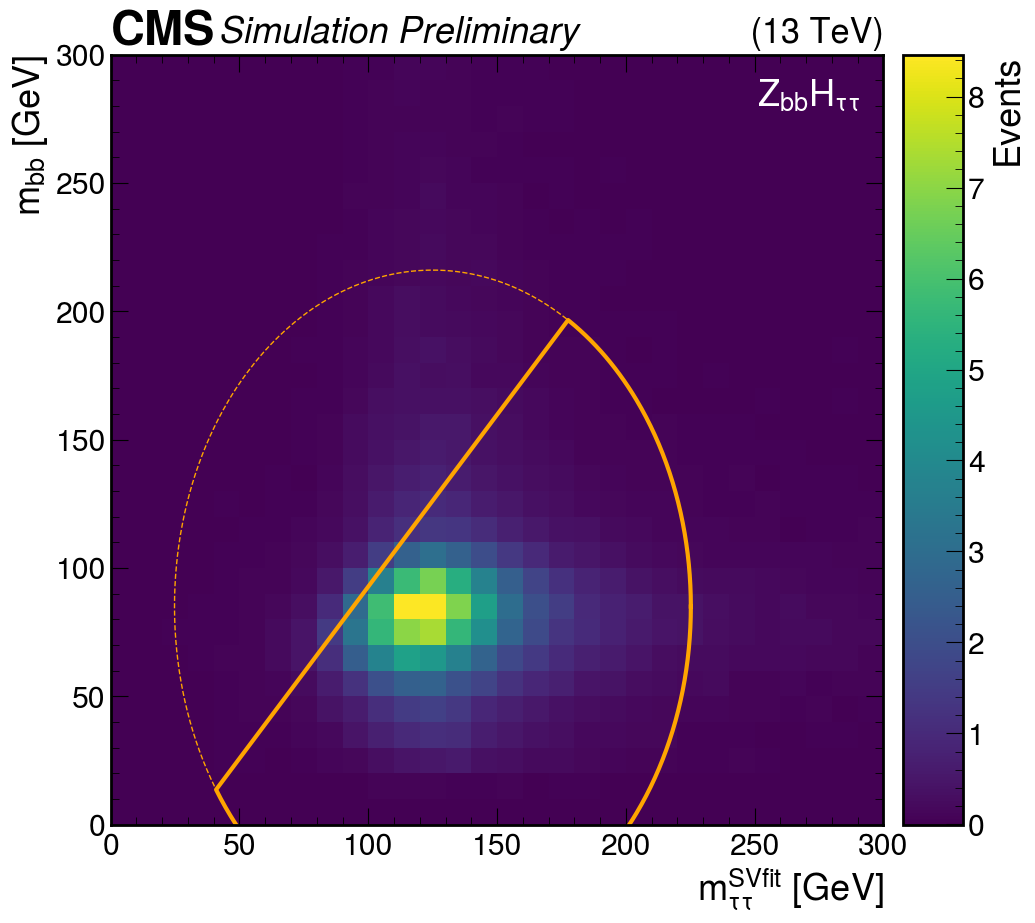

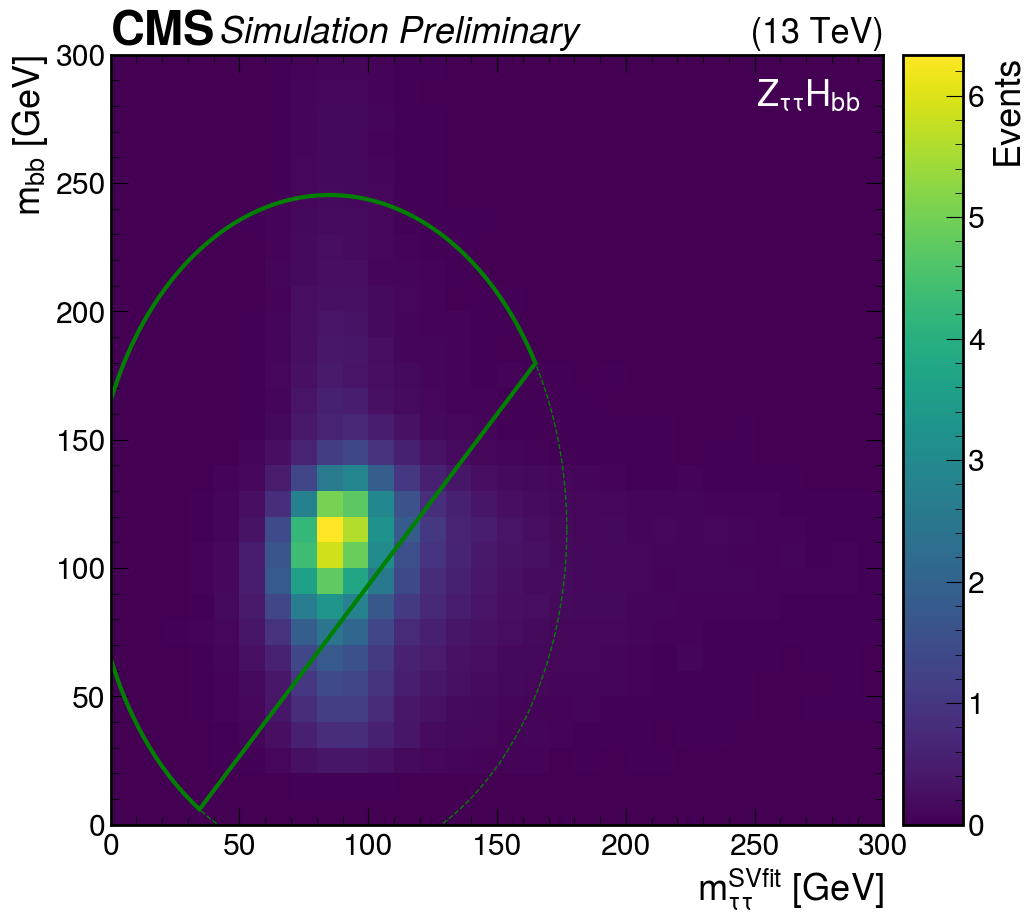

In [36]:
# Plot the stacked ZbbHtt histogram
plt.figure(figsize=(11, 10))
cbar = hep.hist2dplot(stacked_data_zbbhtt, xedges, yedges, cmap='viridis', flow=False, rasterized=True).cbar
# plt.scatter(htt_c,zbb_c, color="orange")
plt.xlim(0,300)
plt.ylim(0,300)
ellipse_zbbhtt = Ellipse(xy=(ellipses["ZbbHtt"]["x"], ellipses["ZbbHtt"]["y"]), width=ellipses["ZbbHtt"]["w"]*2, height=ellipses["ZbbHtt"]["h"]*2, fill=False, ec="tab:orange", lw=3)
# plt.gca().add_patch(ellipse_zbbhtt)
plt.text(0.97, 0.97, r"$Z_{bb}H_{\tau\tau}$", ha="right", va="top", transform=plt.gca().transAxes, color="white")
cbar.set_label("Events")
hep.cms.label("Preliminary")
plt.xlabel(r"$m_{\tau\tau}^{SVfit}$ [GeV]")
plt.ylabel(r"$m_{bb}$ [GeV]")

ellipse_x = ellipses["ZbbHtt"]["x"] + ellipses["ZbbHtt"]["w"] * np.cos(theta)
ellipse_y = ellipses["ZbbHtt"]["y"] + ellipses["ZbbHtt"]["h"] * np.sin(theta)
points_below_line = (ellipse_y < line(ellipse_x, a_perp, b_perp))
ellipse_x_below = ellipse_x[points_below_line]
ellipse_y_below = ellipse_y[points_below_line]
plt.plot(ellipse_x_below, ellipse_y_below, 'r-', linewidth=3, color='orange', label='Ellipse Contour Below Line')

points_above_line = (ellipse_y > line(ellipse_x, a_perp, b_perp))
ellipse_x_above = ellipse_x[points_above_line]
ellipse_y_above = ellipse_y[points_above_line]
plt.plot(ellipse_x_above, ellipse_y_above, '--', linewidth=1, color='orange', label='Ellipse Contour Below Line')

plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZbbHtt_Ellipse_Orthogonal.png')
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZbbHtt_Ellipse_Orthogonal.pdf')

# Plot the stacked ZttHbb histogram
plt.figure(figsize=(11, 10))
cbar = hep.hist2dplot(stacked_data_ztthbb, xedges, yedges, cmap='viridis', flow=False, rasterized=True).cbar
# plt.scatter(ztt_c,hbb_c, color="green")
plt.xlim(0,300)
plt.ylim(0,300)
ellipse_zbbhtt = Ellipse(xy=(ellipses["ZttHbb"]["x"], ellipses["ZttHbb"]["y"]), width=ellipses["ZttHbb"]["w"]*2, height=ellipses["ZttHbb"]["h"]*2, fill=False, ec="tab:green", lw=3)
# plt.gca().add_patch(ellipse_zbbhtt)
plt.text(0.97, 0.97, r"$Z_{\tau\tau}H_{bb}$", ha="right", va="top", transform=plt.gca().transAxes, color="white")
cbar.set_label("Events")
hep.cms.label("Preliminary")
plt.xlabel(r"$m_{\tau\tau}^{SVfit}$ [GeV]")
plt.ylabel(r"$m_{bb}$ [GeV]")

x_line_perp = np.linspace(34.5, 164.5, 100)
y_line_perp = line(x_line_perp, a_perp, b_perp)
plt.plot(x_line_perp, y_line_perp, 'k-', linewidth=3, color='green', label=f'Line: y = {a_perp:.2f}x + {b_perp:.2f}')

ellipse_x = ellipses["ZttHbb"]["x"] + ellipses["ZttHbb"]["w"] * np.cos(theta)
ellipse_y = ellipses["ZttHbb"]["y"] + ellipses["ZttHbb"]["h"] * np.sin(theta)
points_above_line = (ellipse_y > line(ellipse_x, a_perp, b_perp))
ellipse_x_above = ellipse_x[points_above_line]
ellipse_y_above = ellipse_y[points_above_line]
plt.plot(ellipse_x_above, ellipse_y_above, 'r-', linewidth=3, color='green', label='Ellipse Contour Above Line')

points_below_line = (ellipse_y < line(ellipse_x, a_perp, b_perp))
ellipse_x_below = ellipse_x[points_below_line]
ellipse_y_below = ellipse_y[points_below_line]
plt.plot(ellipse_x_below, ellipse_y_below, '--', linewidth=1, color='green', label='Ellipse Contour Above Line')

plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZttHbb_Ellipse_Orthogonal.png')
plt.savefig('/grid_mnt/data__data.polcms/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/FindEllipses/ZttHbb_Ellipse_Orthogonal.pdf')

In [37]:
print(a_perp, b_perp)

1.3333333333333333 -40.0


In [38]:
def is_in_ellipse(x, y, ellipse):
    x0, y0, w, h = ellipse["x"], ellipse["y"], ellipse["w"], ellipse["h"]
    return ((x - x0) ** 2 / w ** 2 + (y - y0) ** 2 / h ** 2) <= 1

x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(x_centers, y_centers)
points = np.vstack([X.ravel(), Y.ravel()]).T

mask_inside_zbbhtt = is_in_ellipse(points[:, 0], points[:, 1], ellipses["ZbbHtt"])
mask_below_line_zbbhtt = points[:, 1] <= line(points[:, 0], a_perp, b_perp)
signal_yield_zbbhtt = stacked_data_zbbhtt.T.flatten()[mask_inside_zbbhtt & mask_below_line_zbbhtt].sum()
print("New Acceptance ZbbHtt = ", signal_yield_zbbhtt/stacked_data_zbbhtt.flatten().sum())

mask_inside_ztthbb = is_in_ellipse(points[:, 0], points[:, 1], ellipses["ZttHbb"])
mask_above_line_ztthbb = points[:, 1] > line(points[:, 0], a_perp, b_perp)
signal_yield_ztthbb = stacked_data_ztthbb.T.flatten()[mask_inside_ztthbb & mask_above_line_ztthbb].sum()
print("New Acceptance ZttHbb = ", signal_yield_ztthbb/stacked_data_ztthbb.flatten().sum())

New Acceptance ZbbHtt =  0.7871563851746578
New Acceptance ZttHbb =  0.6271023142413029
